# Structured and time series data - half hourly dataset

Based on the methodology taken by the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737). See fastai rossman.ipynb

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

Here we will use a Root Mean Square Error loss function to be consistent with other forecasting models used for this project

NB this notebook was divided into two parts thefirst involving a lot of data mungeing that only needs to be done once.

In this part we build a deep learning model with Pytorch


In [144]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [145]:
from fastai.structured import *
from fastai.column_data import *
import feather as ftr
from datetime import timedelta
import random
import heapq

In [146]:
torch.cuda.set_device(0)
#torch.cuda.set_device(1)

torch.cuda.current_device()

0

In [147]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

In [148]:
# These are the usual ipython objects
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

In [149]:
# Get a sorted list of the objects and their sizes
#sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [150]:
PATH='../input/merged_data/'

In [151]:
from IPython.display import HTML, display

### Read in final pre-processed dataset

In [152]:
df = pd.read_csv(f'{PATH}hh_final_544_ids_735_days.csv', low_memory=False)

In [153]:
df.head(n=2)

,Unnamed: 0,index,LCLid,energy(kWh/hh),dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,dayIs_month_end,dayIs_month_start,dayIs_quarter_end,dayIs_quarter_start,dayIs_year_end,dayIs_year_start,dayElapsed,delta_minutes,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,humidity,summary,is_bank_holiday,bank_holiday,day,cloudCover,uvIndex,moonPhase,from_sunrise,to_sunset,Afteris_bank_holiday,Beforeis_bank_holiday,stdorToU,Acorn,Acorn_grouped
0,0,2012-02-05 00:00:00,MAC000006,0.042,2012,2,5,5,6,36,False,False,False,False,False,False,1328400000,-360000,1.32,160.0,-0.12,-0.22,1024.21,-4.68,4.35,snow,0.99,Foggy,False,NaN,2012-02-05,0.85,1.0,0.42,454.0,-1017.0,0,-87840,Std,ACORN-Q,Adversity
1,1,2012-02-05 00:00:00,MAC005178,0.561,2012,2,5,5,6,36,False,False,False,False,False,False,1328400000,-360000,1.32,160.0,-0.12,-0.22,1024.21,-4.68,4.35,snow,0.99,Foggy,False,NaN,2012-02-05,0.85,1.0,0.42,454.0,-1017.0,0,-87840,Std,ACORN-E,Affluent


In [154]:
df.rename(columns={'index': 'day_time'}, inplace=True)

In [155]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [156]:
df['day_time'] = pd.to_datetime(df['day_time'], format='%Y-%m-%d %H:%M:%S')

Count NaNs in ouy target column

In [157]:
df['energy(kWh/hh)'].isna().sum()

6207

In [158]:
#which columns have nan
df.isna().any()

day_time                 False
LCLid                    False
energy(kWh/hh)            True
dayYear                  False
dayMonth                 False
dayWeek                  False
dayDay                   False
dayDayofweek             False
dayDayofyear             False
dayIs_month_end          False
dayIs_month_start        False
dayIs_quarter_end        False
dayIs_quarter_start      False
dayIs_year_end           False
dayIs_year_start         False
dayElapsed               False
delta_minutes            False
visibility               False
windBearing              False
temperature              False
dewPoint                 False
pressure                 False
apparentTemperature      False
windSpeed                False
precipType               False
humidity                 False
summary                  False
is_bank_holiday          False
bank_holiday              True
day                      False
cloudCover                True
uvIndex                   True
moonPhas

In [159]:
nan_energy = df[df['energy(kWh/hh)'].isnull()]

In [160]:
nan_energy.head(n=2)

,day_time,LCLid,energy(kWh/hh),dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,dayIs_month_end,dayIs_month_start,dayIs_quarter_end,dayIs_quarter_start,dayIs_year_end,dayIs_year_start,dayElapsed,delta_minutes,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,humidity,summary,is_bank_holiday,bank_holiday,day,cloudCover,uvIndex,moonPhase,from_sunrise,to_sunset,Afteris_bank_holiday,Beforeis_bank_holiday,stdorToU,Acorn,Acorn_grouped
289,2012-02-05 00:00:00,MAC004954,NaN,2012,2,5,5,6,36,False,False,False,False,False,False,1328400000,-360000,1.320,160.0,-0.12,-0.220,1024.21,-4.68,4.350,snow,0.990,Foggy,False,NaN,2012-02-05,NaN,NaN,NaN,NaN,NaN,0,-87840,Std,ACORN-E,Affluent
6100,2012-02-05 05:30:00,MAC000041,NaN,2012,2,5,5,6,36,False,False,False,False,False,False,1328400000,-359670,4.165,101.5,0.38,0.015,1023.81,-1.47,1.605,snow,0.975,Mostly Cloudy,False,NaN,2012-02-05,NaN,NaN,NaN,NaN,NaN,0,-87840,Std,ACORN-Q,Adversity


Ideally we would investigate further and better interpolate/subset to remove nan but dont have time se we just replace all nan with zero

In [161]:
df.fillna(0,inplace=True)

In [162]:
df.dtypes

day_time                 datetime64[ns]
LCLid                            object
energy(kWh/hh)                  float64
dayYear                           int64
dayMonth                          int64
dayWeek                           int64
dayDay                            int64
dayDayofweek                      int64
dayDayofyear                      int64
dayIs_month_end                    bool
dayIs_month_start                  bool
dayIs_quarter_end                  bool
dayIs_quarter_start                bool
dayIs_year_end                     bool
dayIs_year_start                   bool
dayElapsed                        int64
delta_minutes                     int64
visibility                      float64
windBearing                     float64
temperature                     float64
dewPoint                        float64
pressure                        float64
apparentTemperature             float64
windSpeed                       float64
precipType                       object


These are our final set of engineered features.

## Create features

In [163]:
#joined = pd.read_feather(f'{PATH}joined')
#joined_test = pd.read_feather(f'{PATH}joined_test')

In [164]:
df.head().T.head(len(list(df)))

,0,1,2,3,4
day_time,2012-02-05 00:00:00,2012-02-05 00:00:00,2012-02-05 00:00:00,2012-02-05 00:00:00,2012-02-05 00:00:00
LCLid,MAC000006,MAC005178,MAC000066,MAC004510,MAC004882
energy(kWh/hh),0.042,0.561,0.037,0.254,0.426
dayYear,2012,2012,2012,2012,2012
dayMonth,2,2,2,2,2
dayWeek,5,5,5,5,5
dayDay,5,5,5,5,5
dayDayofweek,6,6,6,6,6
dayDayofyear,36,36,36,36,36
dayIs_month_end,False,False,False,False,False


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

### T/T split

In [165]:
list(df)

['day_time',
 'LCLid',
 'energy(kWh/hh)',
 'dayYear',
 'dayMonth',
 'dayWeek',
 'dayDay',
 'dayDayofweek',
 'dayDayofyear',
 'dayIs_month_end',
 'dayIs_month_start',
 'dayIs_quarter_end',
 'dayIs_quarter_start',
 'dayIs_year_end',
 'dayIs_year_start',
 'dayElapsed',
 'delta_minutes',
 'visibility',
 'windBearing',
 'temperature',
 'dewPoint',
 'pressure',
 'apparentTemperature',
 'windSpeed',
 'precipType',
 'humidity',
 'summary',
 'is_bank_holiday',
 'bank_holiday',
 'day',
 'cloudCover',
 'uvIndex',
 'moonPhase',
 'from_sunrise',
 'to_sunset',
 'Afteris_bank_holiday',
 'Beforeis_bank_holiday',
 'stdorToU',
 'Acorn',
 'Acorn_grouped']

In [166]:
df['day_time'].min(), df['day'].min()

(Timestamp('2012-02-05 00:00:00'), '2012-02-05')

In [167]:
df['day_time'].max(), df['day'].max()

(Timestamp('2014-02-08 23:30:00'), '2014-02-08')

Lets keep last 2 weeks for test and 2 weeks for validation data


In [168]:
#val_date = pd.datetime(2014,1,26)
#test data - last week of data
split_date = pd.datetime(2014,2,2)

In [169]:
split_date

datetime.datetime(2014, 2, 2, 0, 0)

In [170]:
joined_train = df.loc[df['day_time'] < split_date]
joined_test = df.loc[df['day_time'] >= split_date]

In [171]:
len(df), len(joined_train), len(joined_test)

(19192320, 19009536, 182784)

In [172]:
joined_train.head(n=2)

,day_time,LCLid,energy(kWh/hh),dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,dayIs_month_end,dayIs_month_start,dayIs_quarter_end,dayIs_quarter_start,dayIs_year_end,dayIs_year_start,dayElapsed,delta_minutes,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,humidity,summary,is_bank_holiday,bank_holiday,day,cloudCover,uvIndex,moonPhase,from_sunrise,to_sunset,Afteris_bank_holiday,Beforeis_bank_holiday,stdorToU,Acorn,Acorn_grouped
0,2012-02-05,MAC000006,0.042,2012,2,5,5,6,36,False,False,False,False,False,False,1328400000,-360000,1.32,160.0,-0.12,-0.22,1024.21,-4.68,4.35,snow,0.99,Foggy,False,0,2012-02-05,0.85,1.0,0.42,454.0,-1017.0,0,-87840,Std,ACORN-Q,Adversity
1,2012-02-05,MAC005178,0.561,2012,2,5,5,6,36,False,False,False,False,False,False,1328400000,-360000,1.32,160.0,-0.12,-0.22,1024.21,-4.68,4.35,snow,0.99,Foggy,False,0,2012-02-05,0.85,1.0,0.42,454.0,-1017.0,0,-87840,Std,ACORN-E,Affluent


In [173]:
cat_vars = ['dayYear', 'dayMonth', 'dayWeek', 'dayDay', 'dayDayofweek', 'dayDayofyear', 'precipType', 'summary','bank_holiday', 'stdorToU', 'Acorn', 'Acorn_grouped']

#leaving out delta_minutes, looks anomalous
contin_vars = ['dayElapsed', 'visibility','windBearing','temperature',
               'dewPoint','pressure','apparentTemperature','windSpeed','humidity','cloudCover','uvIndex','moonPhase',
               'from_sunrise','to_sunset','Afteris_bank_holiday','Beforeis_bank_holiday']

len(joined_train)

19009536

Convert MAC codes to integer 

In [174]:
#joined_train['LCLid'] = joined_train['LCLid'].map(lambda x: str(x)[3:]).astype('int32')
#joined_test['LCLid'] = joined_test['LCLid'].map(lambda x: str(x)[3:]).astype('int32')

In [175]:
energy = joined_train['energy(kWh/hh)'].values
dep = 'energy(kWh/hh)'
#here 'energy_sum' becomes a df not a series - I use workaround below for
joined_train = joined_train[cat_vars+contin_vars+[dep, 'day_time']].copy()
joined_train.drop(columns=[dep],inplace=True)
joined_train[dep]=energy
print(f"post vals train dep: {type(joined_train[dep])}")

post vals train dep: <class 'pandas.core.series.Series'>


In [176]:
joined_train.head(n=2)

,dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,precipType,summary,bank_holiday,stdorToU,Acorn,Acorn_grouped,dayElapsed,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,cloudCover,uvIndex,moonPhase,from_sunrise,to_sunset,Afteris_bank_holiday,Beforeis_bank_holiday,day_time,energy(kWh/hh)
0,2012,2,5,5,6,36,snow,Foggy,0,Std,ACORN-Q,Adversity,1328400000,1.32,160.0,-0.12,-0.22,1024.21,-4.68,4.35,0.99,0.85,1.0,0.42,454.0,-1017.0,0,-87840,2012-02-05,0.042
1,2012,2,5,5,6,36,snow,Foggy,0,Std,ACORN-E,Affluent,1328400000,1.32,160.0,-0.12,-0.22,1024.21,-4.68,4.35,0.99,0.85,1.0,0.42,454.0,-1017.0,0,-87840,2012-02-05,0.561


In [177]:
#same for test
joined_test = joined_test[cat_vars+contin_vars+[dep, 'day_time','LCLid']].copy()
joined_test.drop(columns=[dep],inplace=True)
joined_test[dep] = 0
print(f"post vals test dep: {type(joined_test[dep])}")

post vals test dep: <class 'pandas.core.series.Series'>


In [178]:
joined_test.head(n=2)

,dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,precipType,summary,bank_holiday,stdorToU,Acorn,Acorn_grouped,dayElapsed,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,cloudCover,uvIndex,moonPhase,from_sunrise,to_sunset,Afteris_bank_holiday,Beforeis_bank_holiday,day_time,LCLid,energy(kWh/hh)
19009536,2014,2,5,2,6,33,rain,Breezy,0,Std,ACORN-A,Affluent,1391299200,12.49,218.0,7.54,2.82,996.84,3.56,7.75,0.72,0.22,1.0,0.1,458.0,-1013.0,44640,0,2014-02-02,MAC005042,0
19009537,2014,2,5,2,6,33,rain,Breezy,0,Std,ACORN-F,Comfortable,1391299200,12.49,218.0,7.54,2.82,996.84,3.56,7.75,0.72,0.22,1.0,0.1,458.0,-1013.0,44640,0,2014-02-02,MAC000201,0


In [179]:
#for v in cat_vars: df_train[v] = df_train[v].astype('category').cat.as_ordered()
for v in cat_vars: 
    print(v)
    joined_train[v] = joined_train[v].astype('category').cat.as_ordered()

dayYear
dayMonth
dayWeek
dayDay
dayDayofweek
dayDayofyear
precipType
summary
bank_holiday
stdorToU
Acorn
Acorn_grouped


In [180]:
#alternatively we could just add df_test to the category re-declaration loop above
apply_cats(joined_test, joined_train)

In [181]:
for v in contin_vars:
    joined_train[v] = joined_train[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

To run on a sample:

In [182]:
#idxs = get_cv_idxs(n, val_pct=150000/n)
#df_samp = df_train.iloc[idxs].set_index("day")
#samp_size = len(df_samp); samp_size

To run on the full dataset:

In [183]:
#use this to create mapper - note we use the train df
samp_size = len(joined_train)
joined_samp = joined_train.set_index("day_time")

We can now process our data...

In [184]:
#keep track of the mapper (44:15)
#can set ignore_flds

In [185]:
df, y, nas, mapper = proc_df(joined_samp, 'energy(kWh/hh)', do_scale=True)
print(f'first n y for df_samp: {y[:10]}')

first n y for df_samp: [0.042 0.561 0.037 0.254 0.426 0.196 0.2   0.052 0.97  0.034]


In [186]:
df.head(2)

,dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,precipType,summary,bank_holiday,stdorToU,Acorn,Acorn_grouped,dayElapsed,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,cloudCover,uvIndex,moonPhase,from_sunrise,to_sunset,Afteris_bank_holiday,Beforeis_bank_holiday
day_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-02-05,1,2,5,5,7,36,2,6,1,1,17,2,-1.729636,-3.283805,-0.381482,-1.859926,-1.39234,0.914874,-2.05021,0.28566,1.484661,1.894545,-0.948735,-0.282941,1.893683,-1.489647,-1.100034,-0.808363
2012-02-05,1,2,5,5,7,36,2,6,1,1,5,3,-1.729636,-3.283805,-0.381482,-1.859926,-1.39234,0.914874,-2.05021,0.28566,1.484661,1.894545,-0.948735,-0.282941,1.893683,-1.489647,-1.100034,-0.808363


In [187]:
joined_test = joined_test.set_index("day_time")

In [188]:
#apply the same mapper to the test set

In [189]:
df_test, _, nas, mapper = proc_df(joined_test, 'energy(kWh/hh)', do_scale=True, skip_flds=['LCLid'],
                                  mapper=mapper, na_dict=nas)

In [190]:
df_test.head(n=2)

,dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,precipType,summary,bank_holiday,stdorToU,Acorn,Acorn_grouped,dayElapsed,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,cloudCover,uvIndex,moonPhase,from_sunrise,to_sunset,Afteris_bank_holiday,Beforeis_bank_holiday
day_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-02-02,3,2,5,2,7,33,1,1,1,1,1,3,1.734469,0.426079,0.25514,-0.578577,-0.80148,-1.581845,-0.891065,2.025947,-0.404563,-1.299904,-0.948735,-1.385401,1.903102,-1.480244,-0.092277,1.214971
2014-02-02,3,2,5,2,7,33,1,1,1,1,6,4,1.734469,0.426079,0.25514,-0.578577,-0.80148,-1.581845,-0.891065,2.025947,-0.404563,-1.299904,-0.948735,-1.385401,1.903102,-1.480244,-0.092277,1.214971


In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on the fastai web site.

One approach is to take the last 10% of rows (sorted by date) as our validation set.

In [191]:
#train_ratio = 0.75
#train_ratio = 0.9
#train_size = int(samp_size * train_ratio)
#val_idx = list(range(train_size, len(df)))

In [194]:
val_date = pd.datetime(2014,1,26)
#test data - last week of data
split_date = pd.datetime(2014,2,2)

val_idx = np.flatnonzero((df.index<split_date) & (df.index>=val_date))

In [195]:
print(f'samp_size: {samp_size}')
print(f'train_ratio: {train_ratio}')
print(f'train_size: {train_size}')
print(f'len(df): {len(df)}')
print(f'val_idx: {len(val_idx)}')

samp_size: 19009536
train_ratio: 0.9
train_size: 16944076
len(df): 19009536
val_idx: 182784


In [196]:
val_idx[:10]

array([18826752, 18826753, 18826754, 18826755, 18826756, 18826757, 18826758, 18826759, 18826760, 18826761])

We use a validation set is using the exact same length of time period as the test set uses 

## DL

We're ready to put together our models.

Root-mean-squared error is the metric we used for other forecast models.

In [199]:
def rmse(y_pred, y_targ):
    return np.sqrt(((y_targ - y_pred) ** 2).mean())

#use 20% greater than biggest max seen in training data
max_y = np.max(y)
y_range = (0, max_y*1.2)

In [200]:
type(y[0])

numpy.float64

We can create a ModelData object directly from out data frame.

pass in the test dataframe in the usual way

In [201]:
print(f'pre cmd, val_idx: {len(val_idx)}')
print(f'df: {len(df)}')
print(f'y: {len(y)}')
print(f'cat_vars: {len(cat_vars)}')
print(f'df_test: {len(df_test)}')

pre cmd, val_idx: 182784
df: 19009536
y: 19009536
cat_vars: 12
df_test: 182784


In [202]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Check levels of categorical variables

In [203]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [204]:
cat_sz

[('dayYear', 4),
 ('dayMonth', 13),
 ('dayWeek', 53),
 ('dayDay', 32),
 ('dayDayofweek', 8),
 ('dayDayofyear', 367),
 ('precipType', 3),
 ('summary', 13),
 ('bank_holiday', 6),
 ('stdorToU', 3),
 ('Acorn', 19),
 ('Acorn_grouped', 5)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [205]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [206]:
emb_szs

[(4, 2),
 (13, 7),
 (53, 27),
 (32, 16),
 (8, 4),
 (367, 50),
 (3, 2),
 (13, 7),
 (6, 3),
 (3, 2),
 (19, 10),
 (5, 3)]

In [207]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', 8)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 7]),
                           ('trainable', True),
                           ('nb_params', 91)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 27]),
                           ('trainable', True),
                           ('nb_params', 1431)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 16]),
                           ('trainable', True),
                           ('nb_params', 512)])),
             ('Embedding-5',
              OrderedDict([('input_shape', [-1]

In [208]:
lr = 1e-3
#lr = 2e-5
m.lr_find()

epoch      trn_loss   val_loss   
    0      0.155309   0.239693  


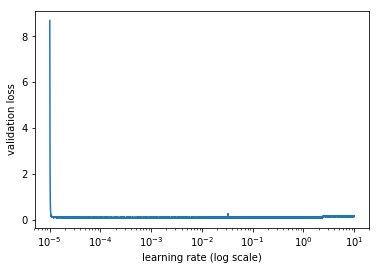

In [209]:
m.sched.plot(100)

### Sample

In [210]:
#m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
#                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
#lr = 1e-3

In [211]:
#m.fit(lr, 3, metrics=[rmse])

In [212]:
#m.fit(lr, 5, metrics=[rmse], cycle_len=1)

In [213]:
#m.fit(lr, 2, metrics=[rmse], cycle_len=4)

### All

In [214]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 2e-5

In [215]:
m.fit(lr, 1, metrics=[rmse])

epoch      trn_loss   val_loss   rmse       
    0      0.100634   0.157171   0.378328  


[array([0.15717]), 0.37832775120254225]

In [216]:
m.fit(lr, 3, metrics=[rmse])

epoch      trn_loss   val_loss   rmse       
    0      0.09863    0.158371   0.378838  
    1      0.094995   0.15593    0.377084  
    2      0.105984   0.156022   0.377016  


[array([0.15602]), 0.3770157867542073]

In [217]:
m.fit(lr, 3, metrics=[rmse], cycle_len=1)

epoch      trn_loss   val_loss   rmse       
    0      0.100901   0.155446   0.376431  
    1      0.104432   0.155405   0.376407  
    2      0.09195    0.155258   0.376308  


[array([0.15526]), 0.3763079823424793]

### Test

In [218]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 2e-5

In [ ]:
m.fit(lr, 3, metrics=[rmse])

epoch      trn_loss   val_loss   rmse       
    0      0.092207   0.157164   0.378365  
 18%|█▊        | 26785/147084 [03:28<15:37, 128.26it/s, loss=0.0989]

In [ ]:
m.fit(lr, 3, metrics=[rmse], cycle_len=1)

In [ ]:
m.save('val0')

In [ ]:
m.load('val0')

In [ ]:
x,y=m.predict_with_targs()

In [ ]:
rmse(x,y)

In [ ]:
pred_test=m.predict(True)

In [ ]:
joined_test['energy(kWh/hh)']=pred_test

In [ ]:
joined_test.head(n=2)

In [ ]:
csv_fn=f'{PATH}tmp/4_6_d_forecast_NN_hh_preds.csv'

In [ ]:
joined_test[['LCLid','energy(kWh/hh)']].to_csv(csv_fn, index=False)